In [3]:
import pandas as pd
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import numpy as np
import os
import PIL
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import l2
import os

In [4]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
stepping	: 3
microcode	: 0xffffffff
cpu MHz		: 2000.146
cache size	: 39424 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single pti ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa

In [5]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [6]:
dataset_path_train = os.listdir('/kaggle/input/eye-diseases-classification/dataset/')
print (dataset_path_train)
print("Types of classes labels found: ", len(dataset_path_train))

['glaucoma', 'normal', 'diabetic_retinopathy', 'cataract']
Types of classes labels found:  4


In [7]:
from pathlib import Path
cataract = Path('/kaggle/input/eye-diseases-classification/dataset/cataract')
diabetic_retinopathy = Path('/kaggle/input/eye-diseases-classification/dataset/diabetic_retinopathy')
glaucoma = Path('/kaggle/input/eye-diseases-classification/dataset/glaucoma')
normal = Path('/kaggle/input/eye-diseases-classification/dataset/normal')

In [8]:
eye_disease_df = pd.DataFrame()
from tqdm import tqdm
for imagepath in tqdm(list(cataract.iterdir()), desc='cataract'):
    eye_disease_df = eye_disease_df.append({
        'image': str(imagepath),
        'eye_disease_type': 0
    }, ignore_index=True)
    
for imagepath in tqdm(list(diabetic_retinopathy.iterdir()), desc='diabetic_retinopathy'):
    eye_disease_df = eye_disease_df.append({
        'image': str(imagepath),
        'eye_disease_type': 1
    }, ignore_index=True)
    
for imagepath in tqdm(list(glaucoma.iterdir()), desc='glaucoma'):
    eye_disease_df = eye_disease_df.append({
        'image': str(imagepath),
        'eye_disease_type': 2
    }, ignore_index=True)
    
for imagepath in tqdm(list(normal.iterdir()), desc='normal'):
    eye_disease_df = eye_disease_df.append({
        'image': str(imagepath),
        'eye_disease_type': 3
    }, ignore_index=True)
    
data_frame = '/kaggle/working/dataset.pickle'
print(f'Saving Dataframe to: {data_frame}')
eye_disease_df.to_pickle(data_frame)

normal: 100%|██████████| 1074/1074 [00:02<00:00, 496.16it/s]

Saving Dataframe to: /kaggle/working/dataset.pickle


In [9]:
eye_disease_df

,image,eye_disease_type
0,/kaggle/input/eye-diseases-classification/data...,0.0
1,/kaggle/input/eye-diseases-classification/data...,0.0
2,/kaggle/input/eye-diseases-classification/data...,0.0
3,/kaggle/input/eye-diseases-classification/data...,0.0
4,/kaggle/input/eye-diseases-classification/data...,0.0
...,...,...
4212,/kaggle/input/eye-diseases-classification/data...,3.0
4213,/kaggle/input/eye-diseases-classification/data...,3.0
4214,/kaggle/input/eye-diseases-classification/data...,3.0
4215,/kaggle/input/eye-diseases-classification/data...,3.0


In [10]:
eye_disease_df['eye_disease_type'].value_counts()

1.0    1098
3.0    1074
0.0    1038
2.0    1007
Name: eye_disease_type, dtype: int64

In [11]:
epochs = 10
learning_rate = 0.001 
retrain = False

In [12]:
from torch import Tensor
from torch.nn import (Conv2d, CrossEntropyLoss, Linear, MaxPool2d, ReLU,Sequential, functional, Sigmoid)
import torch
import torch.nn.init as init
import torch.nn as nn

                      
class EyeDiseaseClassification(nn.Module):
    def __init__(self):
        super(EyeDiseaseClassification, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1,stride=1),
            nn.BatchNorm2d(32,track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1,stride=1),
            nn.BatchNorm2d(32,track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1,stride=1),
            nn.BatchNorm2d(64,track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1,stride=1),
            nn.BatchNorm2d(64,track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1,inplace=False),
            nn.Linear(8 * 8 * 64, 1000),
            nn.ReLU(inplace=True),
            nn.Linear(1000, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1,inplace=False),
            nn.Linear(512, 4)
        )
    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x

eye_disease_cnn = EyeDiseaseClassification()
print(eye_disease_cnn)

EyeDiseaseClassification(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (

In [13]:
from PIL import Image
import numpy as np
from torch import long, tensor
from torch.utils.data.dataset import Dataset
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, RandomOrder

class Eye_Class(Dataset):
    def __init__(self, dataFrame):
        self.dataFrame = dataFrame
        self.transformations = Compose([
            Resize((32, 32)),
            ToTensor(),
            Normalize((0.5667, 0.5198, 0.4955),(0.229, 0.224, 0.225))
        ])
    
    def __getitem__(self, key):
        if isinstance(key, slice):
            raise NotImplementedError('Slicing Supported..')
        
        row_loc = self.dataFrame.iloc[key]
        image_rgb = Image.open(row_loc['image']).convert('RGB')
        #image = (image - mean) / std
        #print(image)
        return {
          'image': self.transformations(image_rgb),
          'eye_disease_type': tensor([row_loc['eye_disease_type']], dtype=long),
          'path': row_loc['image']
        }
    
    def __len__(self):
        return len(self.dataFrame.index)

In [14]:
from sklearn.model_selection import KFold
from typing import Dict, List, Union
import pandas as pd
import torch
import torch.nn.init as init
from torch.nn import (Conv2d, CrossEntropyLoss, Linear, MaxPool2d, ReLU,Sequential, MSELoss, L1Loss)
from torch.optim import Adam
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader
import itertools

def prepare_data(eye_disease_df) -> None:
        eye_disease_dataframe = pd.read_pickle(eye_disease_df)
        print(eye_disease_dataframe['eye_disease_type'].value_counts())
        k_fold = KFold(n_splits=10, shuffle=True)
        training_folds = []
        validation_folds = []
        for training_index, validation_index in k_fold.split(eye_disease_dataframe, eye_disease_dataframe['eye_disease_type']):
            training_folds.append(Eye_Class(eye_disease_dataframe.iloc[training_index]))
            validation_folds.append(Eye_Class(eye_disease_dataframe.iloc[validation_index]))
        return [
            training_folds, validation_folds,CrossEntropyLoss()
            ]

def training_dataloader(train_df) -> DataLoader:
    return DataLoader(train_df, batch_size=32, shuffle=True, num_workers=0)
def validation_dataloader(validate_df) -> DataLoader:
    return DataLoader(validate_df, batch_size=32, num_workers=0)   

training_dfs, validation_dfs, cross_entropy_loss = prepare_data('/kaggle/working/dataset.pickle')
training_dfs

1.0    1098
3.0    1074
0.0    1038
2.0    1007
Name: eye_disease_type, dtype: int64


In [15]:
import warnings
warnings.filterwarnings('ignore')
accuracyvalues = []
training_loss = []

def train_model(train_fold):
    account_list, loss_value_list = ([] for i in range (2))
    optimizer = Adam(eye_disease_cnn.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        total, correct, loss_train = 0, 0, 0.0
        for j, data in enumerate(training_dataloader(train_fold), 0):
            inputs = data['image']
            labels  = data['eye_disease_type']
            labels = labels.flatten()
            outputs = eye_disease_cnn(inputs)
            loss = cross_entropy_loss(outputs, labels)
            loss_value_list.append(loss.item())
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()
            #training accuracy
            total += labels.size(0)
            _, predicted_values = torch.max(outputs.data, 1) 
            correct += (predicted_values == labels).sum().item() 
            loss_train += loss
        print('Training Loss after epoch {} : {} Accuracy: {:.2f}%'.format(epoch, loss_train,(correct / total) * 100))
        accuracyvalues.append((correct / total) * 100)
        training_loss.append(loss_train.detach().numpy())

In [16]:
from numpy import vstack
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

def evaluate_model(validate_fold):
    prediction_values, actual_values = torch.tensor([]), torch.tensor([])
    for i, data in enumerate(validation_dataloader(validate_fold)):
        inputs, targets = data['image'], data['eye_disease_type']
        targets = targets.flatten()
        output = eye_disease_cnn(inputs)
        output = torch.argmax(output,axis=1)
        prediction_values = torch.cat((prediction_values, output.flatten()), dim=0)
        actual_values = torch.cat((actual_values, targets), dim=0)

    return (confusion_matrix(actual_values.numpy(), prediction_values.numpy()),accuracy_score(actual_values, prediction_values),*precision_recall_fscore_support(actual_values.numpy(), prediction_values.numpy(),average='macro'))

In [17]:
import matplotlib.pyplot as plt
import seaborn as sn
fold_outputs = []
fold_con_matrix = np.zeros((4,4))
classes = ['cataract','diabetic_retinopathy','glaucoma','normal']

for fold in range(len(training_dfs)):
    print("Running Fold : "+ str(fold+1))
    print(training_dfs[fold])
    train_model(training_dfs[fold])
    fold_result = evaluate_model(validation_dfs[fold])
    #conf_mat, acc, pre, recall, f-score
    fold_outputs.append(fold_result[1:-1])
    fold_con_matrix = np.add(fold_con_matrix,fold_result[0])
    if fold != len(training_dfs)-1:
        eye_disease_cnn = EyeDiseaseClassification()
    
report = pd.DataFrame(fold_outputs, columns=['accuracy', 'precision', 'recall', 'f1 - score'])
print()
print("Classification Report")
print(report.mean())
print()

Running Fold : 1
Training Loss after epoch 0 : 119.74571228027344 Accuracy: 54.49%
Training Loss after epoch 1 : 80.18817901611328 Accuracy: 69.93%
Training Loss after epoch 2 : 67.0524673461914 Accuracy: 75.89%
Training Loss after epoch 3 : 59.99885177612305 Accuracy: 78.66%
Training Loss after epoch 4 : 53.58101272583008 Accuracy: 81.69%
Training Loss after epoch 5 : 49.66753005981445 Accuracy: 82.37%
Training Loss after epoch 6 : 48.637752532958984 Accuracy: 83.00%
Training Loss after epoch 7 : 42.30026626586914 Accuracy: 85.61%
Training Loss after epoch 8 : 40.8431396484375 Accuracy: 86.27%
Training Loss after epoch 9 : 36.424861907958984 Accuracy: 87.43%
Running Fold : 2
Training Loss after epoch 0 : 129.9307098388672 Accuracy: 50.91%
Training Loss after epoch 1 : 93.2568588256836 Accuracy: 64.08%
Training Loss after epoch 2 : 75.49308776855469 Accuracy: 71.57%
Training Loss after epoch 3 : 63.436378479003906 Accuracy: 76.60%
Training Loss after epoch 4 : 60.04176712036133 Accurac

In [18]:
torch.save(eye_disease_cnn,'eye_disease_classification.pkl')

In [19]:
import os
import torch
if os.path.exists('eye_disease_classification.pkl'): 
    print("Yes")
else:
    print("No model saved")

Yes


To save the Model -> Which helps in skipping the Training Part

In [20]:
import os
import torch
if os.path.exists('eye_disease_classification.pkl'): 
    modelTrained = torch.load('eye_disease_classification.pkl')
else:
    print("No model saved")

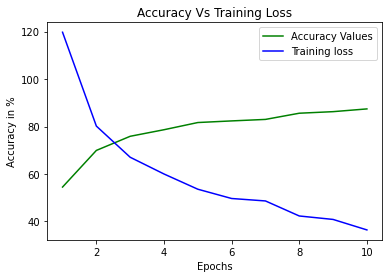

In [21]:
epochvalues = range(1,11)
acc_val = accuracyvalues[:10]
train_loss = training_loss[:10]
plt.plot(epochvalues,acc_val,'g',label='Accuracy Values')
plt.plot(epochvalues,train_loss,'b',label='Training loss')
plt.title('Accuracy Vs Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy in %')
plt.legend()
plt.show()

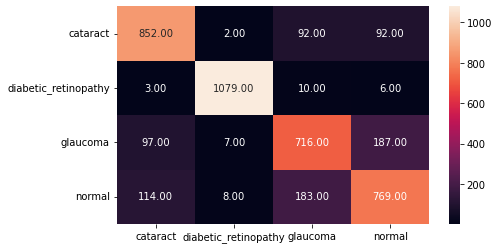

In [22]:
#Plotting Confusion Matrix
df_cm = pd.DataFrame(fold_con_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (7,4))
sn.heatmap(df_cm, annot=True,fmt='.2f')
plt.savefig('output.png')

In [23]:
import random
test_dataset_path = Path('/kaggle/input/eye-diseases-classification/dataset')
test_dataset_list_path = os.listdir(test_dataset_path)
test_randomdisease_path = random.choice(test_dataset_list_path)
test_random = test_dataset_path/test_randomdisease_path
test_random

PosixPath('/kaggle/input/eye-diseases-classification/dataset/diabetic_retinopathy')

In [24]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

class_mapping_values = {0: "cataract", 1: "diabetic_retinopathy", 2: "glaucoma", 3: "normal"}

def prepare_eyedisease_prediction_df():
    test_dataset_path = Path('/kaggle/input/eye-diseases-classification/dataset')
    test_dataset_list_path = os.listdir(test_dataset_path)
    test_randomdisease_path = random.choice(test_dataset_list_path)
    test_random = test_dataset_path/test_randomdisease_path
    test_dataframe = pd.DataFrame()

    #Appending values to the images - Key value pair
    for imagePath in tqdm(list(test_random.iterdir()), desc='cataract'):
        test_dataframe = test_dataframe.append({
            'image': str(imagePath),
            'eye_disease_type': 0
        }, ignore_index=True)

    for imagePath in tqdm(list(test_random.iterdir()), desc='diabetic_retinopathy'):
        test_dataframe = test_dataframe.append({
            'image': str(imagePath),
            'eye_disease_type': 1
        }, ignore_index=True)

    for imagePath in tqdm(list(test_random.iterdir()), desc='glaucoma'):
        test_dataframe = test_dataframe.append({
            'image': str(imagePath),
            'eye_disease_type': 2
        }, ignore_index=True)
        
    for imagePath in tqdm(list(test_random.iterdir()), desc='surgical'):
        test_dataframe = test_dataframe.append({
            'image': str(imagePath),
            'eye_disease_type': 3
        }, ignore_index=True)
        
    
    #Counts the number of images in each category
    print("Length of the Test_Dataframe",len(test_dataframe.value_counts()))
    return Eye_Class(test_dataframe)

surgical: 100%|██████████| 1038/1038 [00:02<00:00, 478.44it/s]


Length of the Test_Dataframe 4152
/kaggle/input/eye-diseases-classification/dataset/cataract/_240_4981563.jpg
Predicted: cataract


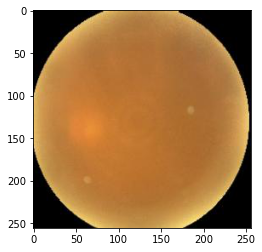

In [25]:
def test_eyedisease_predict():
    test_dataframe = prepare_eyedisease_prediction_df()
    random_sampler = torch.utils.data.RandomSampler(test_dataframe, num_samples=32, replacement=True)
    test_data = iter(DataLoader(test_dataframe, batch_size=32, num_workers=0, sampler=random_sampler)).next()
    inputs,targets = test_data['image'], test_data['eye_disease_type']
    test_output = modelTrained(inputs)
    test_output = torch.argmax(test_output,axis=1)
    rand_val = random.choice(list(range(0,32)))
    print(test_data['path'][rand_val])
    img = Image.open(test_data['path'][rand_val])
    plt.imshow(np.asarray(img))
    print("Predicted:",class_mapping_values[test_output[rand_val].tolist()])

test_eyedisease_predict()

In [26]:
'''def create_mask_for_image(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower_hsv = np.array([0,0,250])
    upper_hsv = np.array([250,255,255])
    
    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return mask'''

'def create_mask_for_image(image):\n    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)\n\n    lower_hsv = np.array([0,0,250])\n    upper_hsv = np.array([250,255,255])\n    \n    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)\n    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))\n    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)\n    return mask'

In [27]:
'''from keras.preprocessing import image
data_kaggle = '/kaggle/input/eye-diseases-classification/dataset/'
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_kaggle, filepath), target_size=size)
    #convert image to array
    img = image.img_to_array(img)
    return img
img = read_img(eye_disease_df['image'][40],(255,255))
img_preprocess = create_mask_for_image(img)
img_preprocess
fig, ax = plt.subplots(1, 2, figsize=(5, 5));
plt.suptitle('RESULT', x=0.5, y=0.8)
ax[0].set_title('ORIGINAL', fontsize=12)
ax[1].set_title('MASK', fontsize=12)
ax[0].imshow(img/255);
ax[1].imshow(img_preprocess);
def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp
img = read_img(eye_disease_df['image'][40],(255,255))
#sharpen the image
image_sharpen = sharpen_image(img)
fig, ax = plt.subplots(1, 2, figsize=(5, 5));
plt.suptitle('RESULT', x=0.5, y=0.8)
plt.tight_layout(1)
ax[0].set_title('ORIGINAL', fontsize=12)
ax[1].set_title('SHARPEN', fontsize=12)
ax[0].imshow(img/255);
ax[1].imshow(image_sharpen);
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

img = Image.open('/kaggle/input/eye-diseases-classification/dataset/cataract/0_left.jpg')
img_aug = transform(img)
img_aug'''

"from keras.preprocessing import image\ndata_kaggle = '/kaggle/input/eye-diseases-classification/dataset/'\ndef read_img(filepath, size):\n    img = image.load_img(os.path.join(data_kaggle, filepath), target_size=size)\n    #convert image to array\n    img = image.img_to_array(img)\n    return img\nimg = read_img(eye_disease_df['image'][40],(255,255))\nimg_preprocess = create_mask_for_image(img)\nimg_preprocess\nfig, ax = plt.subplots(1, 2, figsize=(5, 5));\nplt.suptitle('RESULT', x=0.5, y=0.8)\nax[0].set_title('ORIGINAL', fontsize=12)\nax[1].set_title('MASK', fontsize=12)\nax[0].imshow(img/255);\nax[1].imshow(img_preprocess);\ndef sharpen_image(image):\n    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)\n    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)\n    return image_sharp\nimg = read_img(eye_disease_df['image'][40],(255,255))\n#sharpen the image\nimage_sharpen = sharpen_image(img)\nfig, ax = plt.subplots(1, 2, figsize=(5, 5));\nplt.suptitle('RESULT', x=0.5